# Laboratorio 3 Malware detection
## Security Data Science
### Universidad del valle de Guatemala

Abner Ivan Garcia - 21285
Oscar Esteba Donis - 21610

In [129]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
import tensorflow as tf

# Cargar el conjunto de datos
df = pd.read_csv("malware-dataset.csv", header=0)
df.head()

,sha256,labels,0,1,2,3,4,5,6,7,...,Unnamed: 167,Unnamed: 168,Unnamed: 169,Unnamed: 170,Unnamed: 171,Unnamed: 172,Unnamed: 173,Unnamed: 174,Unnamed: 175,Unnamed: 176
0,5c18291c481a192ed5003084dab2d8a117fd3736359218...,0,LdrUnloadDll,CoUninitialize,NtQueryKey,NtDuplicateObject,GetShortPathNameW,GetSystemInfo,IsDebuggerPresent,GetSystemWindowsDirectoryW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4683faf3da550ffb594cf5513c4cbb34f64df85f27fd1c...,0,NtOpenMutant,GetForegroundWindow,NtQueryKey,DrawTextExW,NtSetInformationFile,RegQueryValueExA,LdrGetProcedureAddress,CoUninitialize,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9a0aea1c7290031d7c3429d0e921f107282cc6eab854ee...,0,GetForegroundWindow,DrawTextExW,GetSystemInfo,IsDebuggerPresent,GetSystemWindowsDirectoryW,NtQueryValueKey,RegCloseKey,GetFileAttributesW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,e0f3e4d5f50afd9c31e51dd9941c5a52d57c7c524f5d11...,0,NtQueryValueKey,LdrUnloadDll,GlobalMemoryStatus,WriteConsoleA,NtOpenKey,LdrGetProcedureAddress,NtTerminateProcess,NtClose,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ec2b6d29992f13e74015ff0b129150b4afae15c593e4b7...,0,LdrUnloadDll,GetSystemTimeAsFileTime,NtOpenKey,WSAStartup,SetUnhandledExceptionFilter,NtTerminateProcess,NtClose,NtAllocateVirtualMemory,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


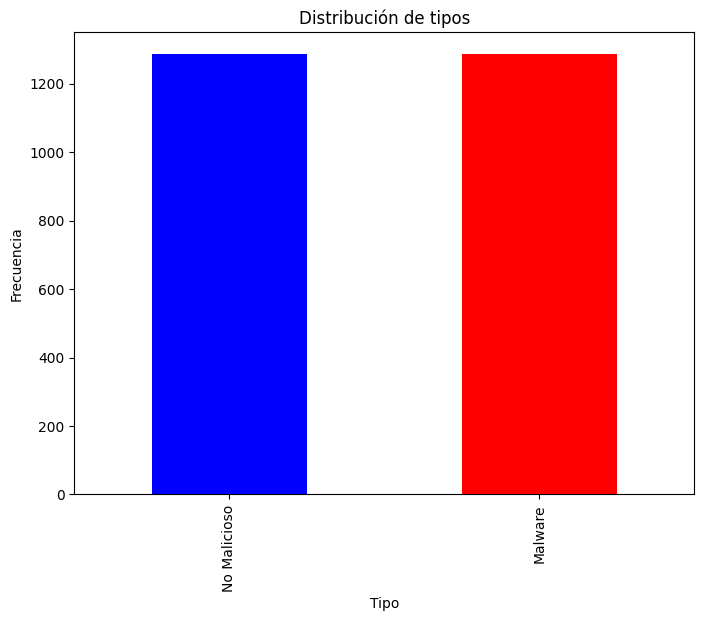

In [ ]:
# creando la gráfica de distribucion de tipos 
plt.figure(figsize=(8, 6)) # tamaño de la gráfica
df['labels'].value_counts().plot(kind='bar', color=['blue', 'red']) # tipo de gráfica
plt.title('Distribución de tipos') # título de la gráfica
plt.xlabel('Tipo') # nombre del eje x
plt.ylabel('Frecuencia') # nombre del eje y
plt.gca().set_xticklabels(['No Malicioso', 'Malware']) # etiquetas del eje x
plt.show() # mostrar la gráfica

## Grafica de las llamadas a las APIs más comunes

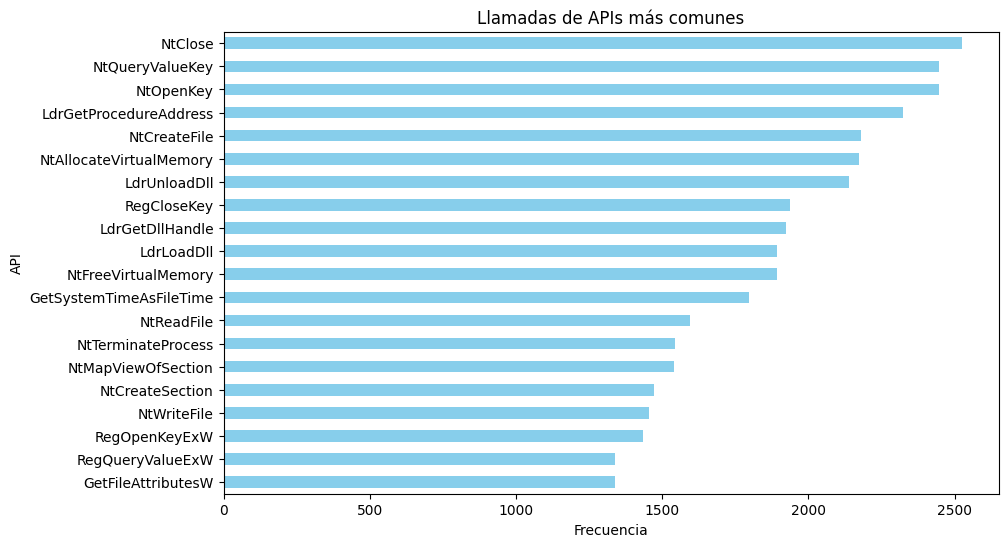

In [131]:
# llamadas a las APIs más comunes
llamadas_apis = df.drop(['sha256', 'labels'], axis=1).stack().value_counts() # contar las llamadas a las APIs
top_calls = llamadas_apis.head(20) # top 20 

plt.figure(figsize=(10, 6)) # graficar
top_calls.plot(kind='barh', color='skyblue') # graficar en barras horizontales
plt.title('Llamadas de APIs más comunes') # título de la gráfica
plt.xlabel('Frecuencia') # etiqueta en x 
plt.ylabel('API') # etiqueta en y 
plt.gca().invert_yaxis() # invertir el eje y para que aparezca la API más común en la parte superior
plt.show()

## Dividir datos en caracteristicas

In [ ]:
le = LabelEncoder() # codificar las etiquetas
df = df.apply(le.fit_transform) # aplicar la codificación a las etiquetas del conjunto de datos

# Dividir el conjunto de datos en características y etiquetas
X = df.drop(['labels', 'sha256'], axis=1) # características 
y = df['labels'] # etiquetas

X # mostrar las características 

,0,1,2,3,4,5,6,7,8,9,...,Unnamed: 167,Unnamed: 168,Unnamed: 169,Unnamed: 170,Unnamed: 171,Unnamed: 172,Unnamed: 173,Unnamed: 174,Unnamed: 175,Unnamed: 176
0,26,2,65,52,29,31,44,37,63,31,...,1,1,1,1,1,1,1,1,1,1
1,35,19,65,9,78,92,46,1,85,98,...,1,1,1,1,1,1,1,1,1,1
2,14,7,26,35,34,77,94,22,105,73,...,1,1,1,1,1,1,1,1,1,1
3,39,31,35,95,66,43,85,54,62,48,...,1,1,1,1,1,1,1,1,1,1
4,26,23,60,94,104,83,56,53,81,48,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2565,3,13,1,77,44,13,83,2,43,85,...,1,1,1,1,1,1,1,1,1,1
2566,31,62,39,68,93,83,78,93,71,66,...,1,1,1,1,1,1,1,1,1,1
2567,10,51,1,77,44,31,100,79,85,25,...,1,1,1,1,1,1,1,1,1,1
2568,28,30,90,21,33,44,45,70,85,51,...,1,1,1,1,1,1,1,1,1,1


In [ ]:
print(X.shape) # imprimir la forma de las características
print(y.shape) # imprimir la forma de las etiquetas

(2570, 175)
(2570,)


In [ ]:
print(y.value_counts()) # imprimimos la distribución de las etiquetas


labels
0    1285
1    1285
Name: count, dtype: int64


In [ ]:
print(y) # imprimimos las etiquetas

0       0
1       0
2       0
3       0
4       0
       ..
2565    1
2566    1
2567    1
2568    1
2569    1
Name: labels, Length: 2570, dtype: int64


Estandarizamos todas las medidas a una unidad única

In [ ]:
scaler = StandardScaler() # estandarizar las características
X_scaled = scaler.fit_transform(X) # aplicar la estandarización a las características

Creamos los conjuntos de entrenamiento y prueba para nuestros modelos

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42) # dividir el conjunto de datos en entrenamiento y prueba

## Primer Modelo

In [138]:
def getPrimerModel(x_data, y_data):
    # Creamos nuestro modelo con una 6 capas
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(x_data.shape[1],)),  # Capa para entrada de datos
        tf.keras.layers.Dense(256, activation='elu'),                                   # Utilizamos elu para evitar el dead neuron problem y poder mejorar el aprendizaje de nuestro modelo.
        tf.keras.layers.BatchNormalization(),                                           # Capa de normatización de lote
        tf.keras.layers.Dense(64, activation='elu'),                                    
        tf.keras.layers.BatchNormalization(),                                           # Capa de normatización de lote
        tf.keras.layers.Dense(32, activation='elu'),
        tf.keras.layers.BatchNormalization(),                                           # Capa de normatización de lote
        tf.keras.layers.Dense(16, activation='leaky_relu'),                             # Capa para eliminar valores negativos
        tf.keras.layers.BatchNormalization(),                                           # Capa de normatización de lote
        tf.keras.layers.Dense(1, activation='sigmoid')                                  # Capa de clasificación, utilizando función sigmoid para clasificación de 2 tipos
    ])

    # Compilamos nuestro modelo con optimizador Adam, binary_crossentropy (para un clasificador de solamento dos valores) y utilizamos el accuracy
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Entrenamos el modelo con 15 epocas, por lotes de 32 elementos y con un conjunto de validación del 10%
    model.fit(x_data, y_data, epochs=10, batch_size=32, validation_split=0.2, verbose=0)

    return model

Evaluamos el modelo con el conjunto de prueba, separamos las predicciones entre: mayor a 0.5 es malicioso y menor a 0.5 no es malicioso

In [ ]:
def getModelPredictions(model, test_data): # Función para obtener las predicciones del modelo
    y_pred = model.predict(test_data) # Obtenemos las predicciones
    y_pred_results = (y_pred > 0.5).astype(int) # Convertimos las predicciones a 0 o 1

    return y_pred, y_pred_results # Regresamos las predicciones

Calculamos las métricas de accuracy, precision, recall y la curva ROC para mejorar el reconocimiento

In [ ]:
model = getPrimerModel(X_train, y_train) # Obtenemos el modelo entrenado

y_predictions, y_predictions_results = getModelPredictions(model, X_test) # Obtenemos las predicciones del modelo

accuracy = accuracy_score(y_test, y_predictions_results) # Obtenemos el acccuracy del modelo
precision = precision_score(y_test, y_predictions_results) # Obtenemos la precisión del modelo
recall = recall_score(y_test, y_predictions_results) # Obtenemos el recall del modelo
roc_auc = roc_auc_score(y_test, y_predictions) # Obtenemos el puntaje ROC y AUC del modelo

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Puntajes ROC y AUC:", roc_auc)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Accuracy: 0.8767833981841764
Precision: 0.8978494623655914
Recall: 0.8542199488491049
Puntajes ROC y AUC: 0.9256259254273792


## Validación Cruzada (Primer Modelo)

Definimos las variables donde vamos a estar almacenando nuestros puntajes

In [ ]:
accuracy_scores = [] # Lista para guardar los puntajes de accuracy
precision_scores = [] # Lista para guardar los puntajes de precisión
recall_scores = [] # Lista para guardar los puntajes de recall
roc_auc_scores = [] # Lista para guardar los puntajes de ROC y AUC

# Cantidad de splits que vamos a dividir nuestro dataset
k = 10

Separamos la data en splits iguales, usando la función StratifiedKFold para poder asegurarnos de que los splits que generemos contengan la misma proporción de emails maliciosos

In [ ]:
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42) # Dividimos nuestro dataset en k splits

Iteramos por cada uno de los splits generados para poder 

In [ ]:
for train_index, test_index in skf.split(X_scaled, y): # Iteramos sobre los splits obtenidos de nuestro dataset
    X_train_split, X_test_split = X_scaled[train_index], X_scaled[test_index] # Obtenemos los datos de entrenamiento y prueba
    y_train_split, y_test_split = y[train_index], y[test_index] # Obtenemos las etiquetas de entrenamiento y prueba

    model = getPrimerModel(X_train_split, y_train_split) # Obtenemos el modelo entrenado con los datos de entrenamiento

    y_predictions_split, y_predictions_split_results = getModelPredictions(model, X_test_split) # Obtenemos las predicciones del modelo

    accuracy_scores.append(accuracy_score(y_test_split, y_predictions_split_results)) # Guardamos el puntaje de accuracy
    precision_scores.append(precision_score(y_test_split, y_predictions_split_results)) # Guardamos el puntaje de precisión
    recall_scores.append(recall_score(y_test_split, y_predictions_split_results)) # Guardamos el puntaje de recall
    roc_auc_scores.append(roc_auc_score(y_test_split, y_predictions_split)) # Guardamos el puntaje de ROC y AUC

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Calculamos algunas estádisticas de las métricas del modelos de la validación cruzada

In [ ]:
accuracy_mean = np.mean(accuracy_scores) # Obtenemos la media de los puntajes de accuracy
precision_mean = np.mean(precision_scores) # Obtenemos la media de los puntajes de precisión
recall_mean = np.mean(recall_scores) # Obtenemos la media de los puntajes de recall
roc_auc_mean = np.mean(roc_auc_scores) # Obtenemos la media de los puntajes de ROC y AUC

accuracy_median = np.median(accuracy_scores) # Obtenemos la mediana de los puntajes de accuracy
precision_median = np.median(precision_scores) # Obtenemos la mediana de los puntajes de precisión
recall_median = np.median(recall_scores) # Obtenemos la mediana de los puntajes de recall
roc_auc_median = np.median(roc_auc_scores) # Obtenemos la mediana de los puntajes de ROC y AUC

accuracy_min = np.min(accuracy_scores) # Obtenemos el mínimo de los puntajes de accuracy
precision_min = np.min(precision_scores) # Obtenemos el mínimo de los puntajes de precisión
recall_min = np.min(recall_scores) # Obtenemos el mínimo de los puntajes de recall
roc_auc_min = np.min(roc_auc_scores) # Obtenemos el mínimo de los puntajes de ROC y AUC

accuracy_max = np.max(accuracy_scores) # Obtenemos el máximo de los puntajes de accuracy
precision_max = np.max(precision_scores) # Obtenemos el máximo de los puntajes de precisión
recall_max = np.max(recall_scores) # Obtenemos el máximo de los puntajes de recall
roc_auc_max = np.max(roc_auc_scores) # Obtenemos el máximo de los puntajes de ROC y AUC

accuracy_std = np.std(accuracy_scores) # Obtenemos la desviación estándar de los puntajes de accuracy
precision_std = np.std(precision_scores) # Obtenemos la desviación estándar de los puntajes de precisión
recall_std = np.std(recall_scores) # Obtenemos la desviación estándar de los puntajes de recall
roc_auc_std = np.std(roc_auc_scores) # Obtenemos la desviación estándar de los puntajes de ROC y AUC

print("Accuracy:")
print("Media de Accuracy:", accuracy_mean)
print("Mediana de Accuracy:", accuracy_median)
print("Máximo de Accuracy:", accuracy_max)
print("Mínimo de Accuracy:", accuracy_min)
print("Desviación Estandar de Accuracy:", accuracy_std)

print("\nPrecision:")
print("Media de Precision:", precision_mean)
print("Mediana de Precision:", precision_median)
print("Máximo de Precision:", precision_max)
print("Mínimo de Precision:", precision_min)
print("Desviación Estandar de Precision:", precision_std)

print("\nRecall:")
print("Media de Recall:", recall_mean)
print("Mediana de Recall:", recall_median)
print("Máximo de Recall:", recall_max)
print("Mínimo de Recall:", recall_min)
print("Desviación Estandar de Recall:", recall_std)

print("\nROC AUC:")
print("Media de ROC AUC:", roc_auc_mean)
print("Mediana de ROC AUC:", roc_auc_median)
print("Máximo de ROC AUC:", roc_auc_max)
print("Mínimo de ROC AUC:", roc_auc_min)
print("Desviación Estandar de ROC AUC:", roc_auc_std)

Accuracy:
Media de Accuracy: 0.8801556420233464
Mediana de Accuracy: 0.8871595330739299
Máximo de Accuracy: 0.9221789883268483
Mínimo de Accuracy: 0.8287937743190662
Desviación Estandar de Accuracy: 0.026321454514066554

Precision:
Media de Precision: 0.9362183079905531
Mediana de Precision: 0.9282828282828283
Máximo de Precision: 0.990909090909091
Mínimo de Precision: 0.8968253968253969
Desviación Estandar de Precision: 0.02859296814980589

Recall:
Media de Recall: 0.8171753875968992
Mediana de Recall: 0.828125
Máximo de Recall: 0.8914728682170543
Mínimo de Recall: 0.7131782945736435
Desviación Estandar de Recall: 0.053814146105247235

ROC AUC:
Media de ROC AUC: 0.9278100775193799
Mediana de ROC AUC: 0.926296027131783
Máximo de ROC AUC: 0.9561531007751938
Mínimo de ROC AUC: 0.8954699612403101
Desviación Estandar de ROC AUC: 0.01774597784856791


## Segundo Modelo (Gemini)

Instalamos la librería de google-generativeai

In [145]:
%pip install -U -q google-generativeai

Note: you may need to restart the kernel to use updated packages.


Importamos las librería necesarias para nuestro modelo

In [ ]:
import re # importar la librería re para trabajar con expresiones regulares
import tqdm # importar la librería tqdm para mostrar barras de progreso
import keras # importar la librería keras
import numpy as np # importar la librería numpy
import pandas as pd # importar la librería pandas
import dotenv # importar la librería dotenv
import os # importar la librería os

import google.generativeai as genai # importar la librería generativeai de google

import seaborn as sns # importar la librería seaborn
import matplotlib.pyplot as plt # importar la librería matplotlib.pyplot

from keras import layers # importar el módulo layers de keras
from matplotlib.ticker import MaxNLocator # importar MaxNLocator de matplotlib.ticker
from sklearn.datasets import fetch_20newsgroups # importar fetch_20newsgroups de sklearn.datasets
import sklearn.metrics as skmetrics # importar sklearn.metrics as skmetrics

Configuramos el acceso con nuestra llave de Google API, para poder utilizar los servicios de AI de Google

In [ ]:
dotenv.load_dotenv() # cargar las variables de entorno

GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY") # obtener la clave de la API de google
# client = genai.Client(api_key=GOOGLE_API_KEY)
genai.configure(api_key=GOOGLE_API_KEY) # configurar la clave de la API de google

In [ ]:
for m in genai.list_models(): # iterar sobre los modelos disponibles
  if 'embedContent' in m.supported_generation_methods: # si el modelo soporta la generación de contenido
    print(m.name) # imprimir el nombre del modelo

models/embedding-001
models/text-embedding-004


Extraemos los datos otra vez para realizar el preprocesamiento

In [ ]:
mails = pd.read_csv("malware-dataset.csv", header=0) # cargar el conjunto de datos
mails.head() # mostrar los primeros registros del conjunto de datos

,sha256,labels,0,1,2,3,4,5,6,7,...,Unnamed: 167,Unnamed: 168,Unnamed: 169,Unnamed: 170,Unnamed: 171,Unnamed: 172,Unnamed: 173,Unnamed: 174,Unnamed: 175,Unnamed: 176
0,5c18291c481a192ed5003084dab2d8a117fd3736359218...,0,LdrUnloadDll,CoUninitialize,NtQueryKey,NtDuplicateObject,GetShortPathNameW,GetSystemInfo,IsDebuggerPresent,GetSystemWindowsDirectoryW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4683faf3da550ffb594cf5513c4cbb34f64df85f27fd1c...,0,NtOpenMutant,GetForegroundWindow,NtQueryKey,DrawTextExW,NtSetInformationFile,RegQueryValueExA,LdrGetProcedureAddress,CoUninitialize,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9a0aea1c7290031d7c3429d0e921f107282cc6eab854ee...,0,GetForegroundWindow,DrawTextExW,GetSystemInfo,IsDebuggerPresent,GetSystemWindowsDirectoryW,NtQueryValueKey,RegCloseKey,GetFileAttributesW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,e0f3e4d5f50afd9c31e51dd9941c5a52d57c7c524f5d11...,0,NtQueryValueKey,LdrUnloadDll,GlobalMemoryStatus,WriteConsoleA,NtOpenKey,LdrGetProcedureAddress,NtTerminateProcess,NtClose,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ec2b6d29992f13e74015ff0b129150b4afae15c593e4b7...,0,LdrUnloadDll,GetSystemTimeAsFileTime,NtOpenKey,WSAStartup,SetUnhandledExceptionFilter,NtTerminateProcess,NtClose,NtAllocateVirtualMemory,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Separamos nuestra variable objetivo de las variables predictoras

In [ ]:
X_data = mails.drop(['labels', 'sha256'], axis=1) # características del conjunto de datos
y_data = mails['labels'] # etiquetas del conjunto de datos

X_data # mostrar las características del conjunto de datos

,0,1,2,3,4,5,6,7,8,9,...,Unnamed: 167,Unnamed: 168,Unnamed: 169,Unnamed: 170,Unnamed: 171,Unnamed: 172,Unnamed: 173,Unnamed: 174,Unnamed: 175,Unnamed: 176
0,LdrUnloadDll,CoUninitialize,NtQueryKey,NtDuplicateObject,GetShortPathNameW,GetSystemInfo,IsDebuggerPresent,GetSystemWindowsDirectoryW,NtClose,GetFileVersionInfoSizeW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NtOpenMutant,GetForegroundWindow,NtQueryKey,DrawTextExW,NtSetInformationFile,RegQueryValueExA,LdrGetProcedureAddress,CoUninitialize,NtQueryValueKey,RegCloseKey,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,GetForegroundWindow,DrawTextExW,GetSystemInfo,IsDebuggerPresent,GetSystemWindowsDirectoryW,NtQueryValueKey,RegCloseKey,GetFileAttributesW,RegQueryValueExW,NtMapViewOfSection,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NtQueryValueKey,LdrUnloadDll,GlobalMemoryStatus,WriteConsoleA,NtOpenKey,LdrGetProcedureAddress,NtTerminateProcess,NtClose,NtAllocateVirtualMemory,LdrGetDllHandle,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,LdrUnloadDll,GetSystemTimeAsFileTime,NtOpenKey,WSAStartup,SetUnhandledExceptionFilter,NtTerminateProcess,NtClose,NtAllocateVirtualMemory,NtQueryAttributesFile,LdrGetDllHandle,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2565,CreateToolhelp32Snapshot,GetCursorPos,CoUninitialize,RegCloseKey,LdrUnloadDll,DrawTextExW,NtSetInformationFile,CopyFileA,GetSystemWindowsDirectoryW,NtQueryValueKey,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2566,NtDuplicateObject,RegCloseKey,LdrUnloadDll,NtSetInformationFile,RegQueryValueExA,NtTerminateProcess,NtQueryValueKey,RegQueryValueExW,NtFreeVirtualMemory,NtCreateThreadEx,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2567,GetCursorPos,NtOpenSection,CoUninitialize,RegCloseKey,LdrUnloadDll,GetSystemInfo,RegQueryValueExA,NtTerminateProcess,NtQueryValueKey,GetFileAttributesW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2568,NtAllocateVirtualMemory,LdrGetProcedureAddress,SetUnhandledExceptionFilter,GetFileType,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetDllHandle,NtProtectVirtualMemory,NtQueryValueKey,LdrUnloadDll,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Realizamos el preprocesamiento a los datos (Solamente a nuestras variables predictoras)

In [ ]:
# Le quitamos todas las mayúsculas y los guiones bajos de nuestros textos
X_data = X_data.applymap(lambda x: x.lower().replace("_", "") if isinstance(x, str) else x)
X_data # mostrar las características del conjunto de datos después de la limpieza

/var/folders/wx/3fwd1ycn21q0f_72nz8kjrr00000gn/T/ipykernel_31384/1094075227.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X_data = X_data.applymap(lambda x: x.lower().replace("_", "") if isinstance(x, str) else x)


,0,1,2,3,4,5,6,7,8,9,...,Unnamed: 167,Unnamed: 168,Unnamed: 169,Unnamed: 170,Unnamed: 171,Unnamed: 172,Unnamed: 173,Unnamed: 174,Unnamed: 175,Unnamed: 176
0,ldrunloaddll,couninitialize,ntquerykey,ntduplicateobject,getshortpathnamew,getsysteminfo,isdebuggerpresent,getsystemwindowsdirectoryw,ntclose,getfileversioninfosizew,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ntopenmutant,getforegroundwindow,ntquerykey,drawtextexw,ntsetinformationfile,regqueryvalueexa,ldrgetprocedureaddress,couninitialize,ntqueryvaluekey,regclosekey,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,getforegroundwindow,drawtextexw,getsysteminfo,isdebuggerpresent,getsystemwindowsdirectoryw,ntqueryvaluekey,regclosekey,getfileattributesw,regqueryvalueexw,ntmapviewofsection,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ntqueryvaluekey,ldrunloaddll,globalmemorystatus,writeconsolea,ntopenkey,ldrgetprocedureaddress,ntterminateprocess,ntclose,ntallocatevirtualmemory,ldrgetdllhandle,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ldrunloaddll,getsystemtimeasfiletime,ntopenkey,wsastartup,setunhandledexceptionfilter,ntterminateprocess,ntclose,ntallocatevirtualmemory,ntqueryattributesfile,ldrgetdllhandle,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2565,createtoolhelp32snapshot,getcursorpos,couninitialize,regclosekey,ldrunloaddll,drawtextexw,ntsetinformationfile,copyfilea,getsystemwindowsdirectoryw,ntqueryvaluekey,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2566,ntduplicateobject,regclosekey,ldrunloaddll,ntsetinformationfile,regqueryvalueexa,ntterminateprocess,ntqueryvaluekey,regqueryvalueexw,ntfreevirtualmemory,ntcreatethreadex,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2567,getcursorpos,ntopensection,couninitialize,regclosekey,ldrunloaddll,getsysteminfo,regqueryvalueexa,ntterminateprocess,ntqueryvaluekey,getfileattributesw,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2568,ntallocatevirtualmemory,ldrgetprocedureaddress,setunhandledexceptionfilter,getfiletype,getsystemtimeasfiletime,ldrloaddll,ldrgetdllhandle,ntprotectvirtualmemory,ntqueryvaluekey,ldrunloaddll,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
def combine_functions(row): # función para combinar las funciones de cada fila
    # filtramos los valores nulos y convertimos las funciones a cadenas
    functions = [str(func) for func in row if pd.notna(func)]
    return ' '.join(functions) # regresamos las funciones combinadas 


X_data['Text'] = X_data.apply(combine_functions, axis=1) # aplicamos la función a cada fila del conjunto de datos

X_data = X_data[['Text']] # seleccionamos solo la columna de texto del conjunto de datos

X_data['Labels'] = y_data # añadimos las etiquetas al conjunto de datos de texto

X_data # mostrar el conjunto de datos de texto

/var/folders/wx/3fwd1ycn21q0f_72nz8kjrr00000gn/T/ipykernel_31384/1596551428.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_data['Labels'] = y_data


,Text,Labels
0,ldrunloaddll couninitialize ntquerykey ntdupli...,0
1,ntopenmutant getforegroundwindow ntquerykey dr...,0
2,getforegroundwindow drawtextexw getsysteminfo ...,0
3,ntqueryvaluekey ldrunloaddll globalmemorystatu...,0
4,ldrunloaddll getsystemtimeasfiletime ntopenkey...,0
...,...,...
2565,createtoolhelp32snapshot getcursorpos couninit...,1
2566,ntduplicateobject regclosekey ldrunloaddll nts...,1
2567,getcursorpos ntopensection couninitialize regc...,1
2568,ntallocatevirtualmemory ldrgetprocedureaddress...,1


In [ ]:
train_df, test_df = train_test_split(X_data, test_size=0.3, random_state=42) # dividir el conjunto de datos en entrenamiento y prueba

print("Training set size:", train_df.shape) # imprimir el tamaño del conjunto de datos de entrenamiento
print("Test set size:", test_df.shape) # imprimir el tamaño del conjunto de datos de prueba
train_df # mostrar el conjunto de datos de entrenamiento


Training set size: (1799, 2)
Test set size: (771, 2)


,Text,Labels
2519,ntqueryvaluekey ldrunloaddll regclosekey ntrea...,1
2482,getcursorpos deviceiocontrol couninitialize re...,1
1102,ldrunloaddll ntopensection couninitialize regc...,0
642,ldrunloaddll ntopenkey setunhandledexceptionfi...,0
1521,ntqueryvaluekey ldrunloaddll ntreadfile getfil...,1
...,...,...
1638,getnativesysteminfo deviceiocontrol couninitia...,1
1095,regcreatekeyexw getnativesysteminfo deviceioco...,0
1130,ldrunloaddll getfiletype regclosekey ldrgetdll...,0
1294,regclosekey regcreatekeyexa getfilesize ntopen...,1


In [ ]:
from tqdm.auto import tqdm # importar tqdm para mostrar barras de progreso
tqdm.pandas() # utilizar tqdm para mostrar barras de progreso

from google.api_core import retry # importar retry de google.api_core

def make_embed_text_fn(model): # función para obtener los embeddings de un texto
    @retry.Retry(timeout=300.0) # reintentar la solicitud si falla
    def embed_fn(text: str) -> list[float]: # función para obtener los embeddings de un texto
        chunks = [text[i:i+1000] for i in range(0, len(text), 1000)] # dividir el texto en fragmentos de 1000 caracteres
        
        embeddings = [] # lista para guardar los embeddings de los fragmentos del texto
        for chunk in chunks: # iterar sobre los fragmentos del texto 
            embedding = genai.embed_content(model=model,
                                          content=chunk,
                                          task_type="classification") # obtener los embeddings del fragmento del texto
            embeddings.append(embedding['embedding']) # añadir los embeddings a la lista de embeddings
            
        # regresar el promedio de los embeddings de los fragmentos del texto
        if embeddings:
            return np.mean(embeddings, axis=0)
        return None
    return embed_fn # regresar la función para obtener los embeddings de un texto

def create_embeddings(model, df): # función para crear los embeddings de un conjunto de datos de texto
  df['Embeddings'] = df['Text'].progress_apply(make_embed_text_fn(model)) # aplicar la función para obtener los embeddings a cada texto del conjunto de datos
  return df # regresar el conjunto de datos con los embeddings

In [ ]:
model = 'models/text-embedding-004' # modelo de embeddings de texto
df_train = create_embeddings(model, train_df) # crear los embeddings del conjunto de datos de entrenamiento
df_test = create_embeddings(model, test_df) # crear los embeddings del conjunto de datos de prueba

  0%|          | 0/1799 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

In [ ]:
def build_classification_model(input_size: int, num_classes: int) -> keras.Model: # función para construir un modelo de clasificación
  inputs = keras.Input(shape=(input_size,)) # capa de entrada del modelo
  x = layers.Dense(input_size, activation='relu')(inputs) # capa densa con activación relu
  x = layers.Dense(128, activation='elu')(x) # capa densa con activación elu
  x = layers.Dense(64, activation='elu')(x) # capa densa con activación elu
  x = layers.Dense(32, activation='elu')(x) # capa densa con activación elu
  x = layers.Dense(16, activation='leaky_relu')(x) # capa densa con activación leaky_relu
  x = layers.Dense(num_classes, activation='sigmoid')(x) # capa densa con activación sigmoid
  return keras.Model(inputs=[inputs], outputs=x) # regresar el modelo de clasificación

In [ ]:

NUM_EPOCHS = 15 # número de épocas
BATCH_SIZE = 32 # tamaño del lote

# Dividir el conjunto de datos de entrenamiento en características y etiquetas
y_train = df_train['Labels'] # etiquetas del conjunto de datos de entrenamiento
x_train = np.stack(df_train['Embeddings'], axis=0) # características del conjunto de datos de entrenamiento
y_val = df_test['Labels'] # etiquetas del conjunto de datos de prueba
x_val = np.stack(df_test['Embeddings'], axis=0) # características del conjunto de datos de prueba

In [ ]:
def getSegundoModel(x_train, y_train, embedding_size, showSummary=False): # función para obtener el segundo modelo

    classifier = build_classification_model(embedding_size, 1) # construir el modelo de clasificación
    
    if showSummary: # si se desea mostrar el resumen del modelo
        classifier.summary() # mostrar el resumen del modelo 

    classifier.compile(loss = keras.losses.BinaryCrossentropy(from_logits=True),
                    optimizer = keras.optimizers.Adam(learning_rate=0.001),
                    metrics=['accuracy']) # compilar el modelo con la función de pérdida, optimizador y métricas


    history = classifier.fit(x=x_train,
                            y=y_train,
                            batch_size=BATCH_SIZE,
                            epochs=NUM_EPOCHS, verbose=1 if showSummary else 0) # entrenar el modelo con las características y etiquetas de entrenamiento
    
    return classifier, history # regresar el modelo y el historial de entrenamiento

In [ ]:
embedding_size = len(df_train['Embeddings'].iloc[0]) # tamaño de los embeddings de texto

classifier, history = getSegundoModel(x_train, y_train, embedding_size, True) # obtener el segundo modelo

classifier.evaluate(x=x_val, y=y_val, return_dict=True) # evaluar el modelo con las características y etiquetas de prueba

Model: "functional_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_55 (InputLayer)     │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_326 (Dense)               │ (None, 768)            │       590,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_327 (Dense)               │ (None, 128)            │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_328 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_329 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_330 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_331 (Dense)               │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 699,905 (2.67 MB)

 Trainable params: 699,905 (2.67 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/backend/tensorflow/nn.py:707: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6031 - loss: 0.6542 
Epoch 2/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7759 - loss: 0.4469
Epoch 3/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8603 - loss: 0.3133
Epoch 4/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8763 - loss: 0.2970
Epoch 5/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8983 - loss: 0.2740
Epoch 6/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9203 - loss: 0.2246
Epoch 7/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8881 - loss: 0.2662
Epoch 8/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8920 - loss: 0.2760
Epoch 9/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9238 - loss: 0.2145
Epoch 10/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9138 - loss: 0.2310
Epoch 11/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8914 - loss: 0.2624
Epoch 12/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9179 - loss: 0.2258

{'accuracy': 0.8910505771636963, 'loss': 0.28481486439704895}

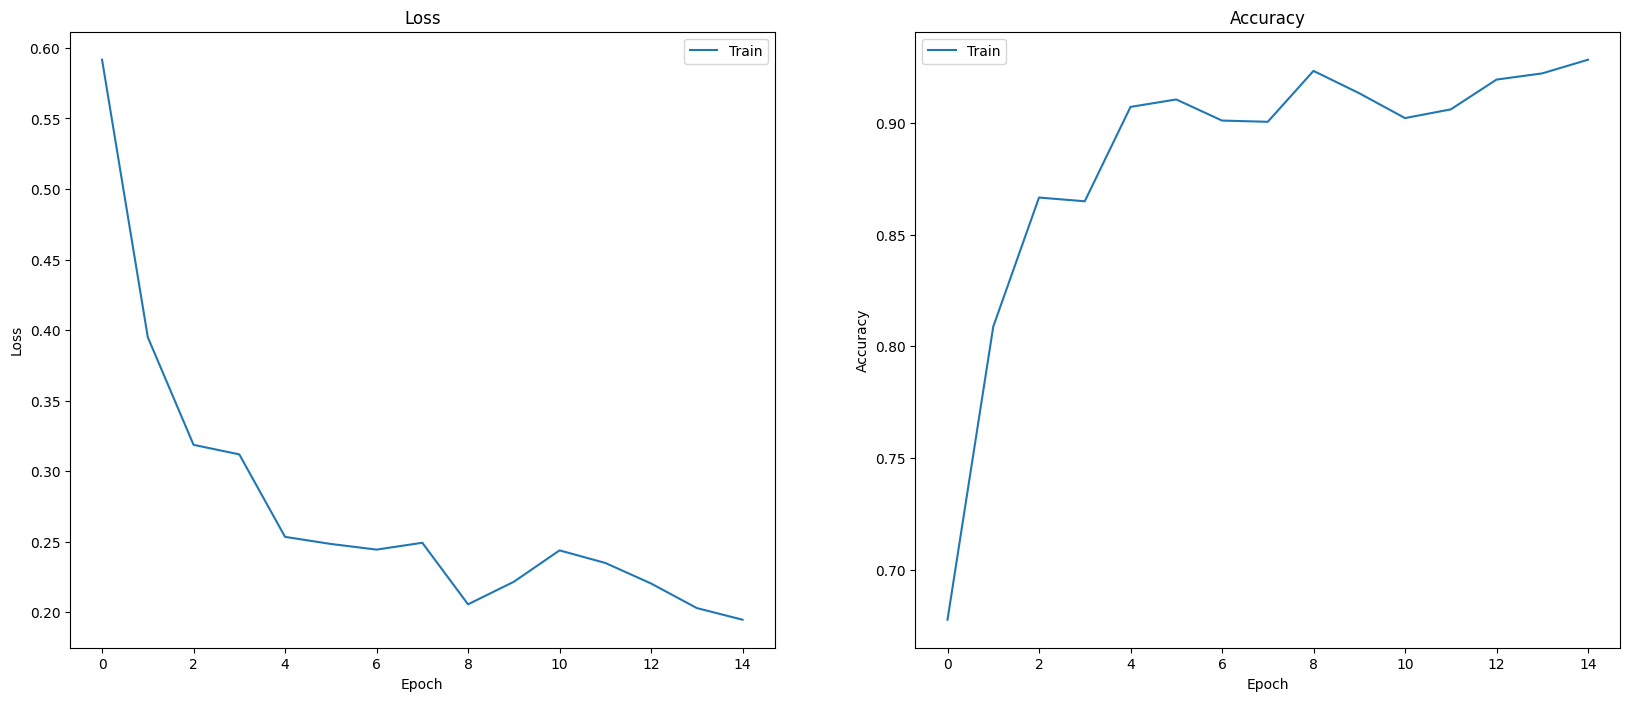

In [ ]:
def plot_history(history): # función para graficar las curvas de aprendizaje
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(1,2) # crear una figura con dos subgráficos
  fig.set_size_inches(20, 8) # tamaño de

  # Plot loss
  ax1.set_title('Loss') # título del gráfico
  ax1.plot(history.history['loss'], label = 'train') # gráficar la pérdida de entrenamiento
  ax1.set_ylabel('Loss') # etiqueta del eje y 

  ax1.set_xlabel('Epoch') # etiqueta del eje x
  ax1.legend(['Train', 'Validation']) # leyenda del gráfico 

  # Plot accuracy
  ax2.set_title('Accuracy') # título del gráfico
  ax2.plot(history.history['accuracy'],  label = 'train') # gráficar la precisión de entrenamiento
  ax2.set_ylabel('Accuracy') # etiqueta del eje y
  ax2.set_xlabel('Epoch') # etiqueta del eje x 
  ax2.legend(['Train', 'Validation']) # leyenda del gráfico 

  plt.show()

plot_history(history) # graficar las curvas de aprendizaje

In [ ]:
y_hat = classifier.predict(x=x_val) # obtener las predicciones del modelo
y_hat = np.squeeze(y_hat) # eliminar las dimensiones de tamaño 1 
y_hat = (y_hat > 0.5).astype(int) # convertir las predicciones a 0 o 1

print("Accuracy:", skmetrics.accuracy_score(y_val, y_hat)) # imprimir el accuracy del modelo

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Accuracy: 0.8910505836575876


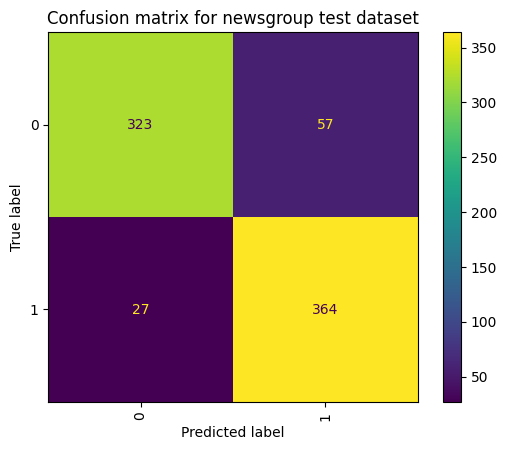

In [ ]:
cm = skmetrics.confusion_matrix(y_val, y_hat) # obtener la matriz de confusión
disp = skmetrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1]) # mostrar la matriz de confusión
disp.plot(xticks_rotation='vertical') # graficar la matriz de confusión
plt.title('Confusion matrix for newsgroup test dataset'); # título de la matriz de confusión
plt.grid(False) # quitar las líneas de la cuadrícula

## Validación Cruzada (Segundo Modelo)

In [ ]:
accuracy_scores_second = [] # Lista para guardar los puntajes de accuracy
precision_scores_second = [] # Lista para guardar los puntajes de precisión
recall_scores_second = [] # Lista para guardar los puntajes de recall
roc_auc_scores_second = [] # Lista para guardar los puntajes de ROC y AUC

# Cantidad de splits que vamos a dividir nuestro dataset
k = 10

In [ ]:
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42) # Dividimos nuestro dataset en k splits

In [ ]:
df_train_x = np.stack(df_train['Embeddings'], axis=0) # características del conjunto de datos de entrenamiento
df_train_y = df_train['Labels'] # etiquetas del conjunto de datos de entrenamiento

df_test_x = np.stack(df_test['Embeddings'], axis=0) # características del conjunto de datos de prueba
df_test_y = df_test['Labels'] # etiquetas del conjunto de datos de prueba

df_x_data = np.vstack((df_train_x, df_test_x)) # características del conjunto de datos

df_y_data = np.concatenate((df_train_y, df_test_y), axis=0) # etiquetas del conjunto de datos

In [ ]:
for train_index, test_index in skf.split(df_x_data, df_y_data): # Iteramos sobre los splits obtenidos de nuestro dataset
    X_train_split, X_test_split = df_x_data[train_index], df_x_data[test_index] # Obtenemos los datos de entrenamiento y prueba
    y_train_split, y_test_split = df_y_data[train_index], df_y_data[test_index] # Obtenemos las etiquetas de entrenamiento y prueba

    embedding_size = X_train_split.shape[1] # tamaño de los embeddings de texto

    model, history = getSegundoModel(X_train_split, y_train_split, embedding_size) # Obtenemos el modelo entrenado con los datos de entrenamiento

    y_predictions_split = model.predict(X_test_split) # Obtenemos las predicciones del modelo
    y_predictions_split = np.squeeze(y_predictions_split) # Eliminamos las dimensiones de tamaño 1
    y_predictions_split_results = (y_predictions_split > 0.5).astype(int) # Convertimos las predicciones a 0 o 1

    accuracy_scores_second.append(accuracy_score(y_test_split, y_predictions_split_results)) # Guardamos el puntaje de accuracy
    precision_scores_second.append(precision_score(y_test_split, y_predictions_split_results)) # Guardamos el puntaje de precisión
    recall_scores_second.append(recall_score(y_test_split, y_predictions_split_results)) # Guardamos el puntaje de recall
    roc_auc_scores_second.append(roc_auc_score(y_test_split, y_predictions_split)) # Guardamos el puntaje de ROC y AUC

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/backend/tensorflow/nn.py:707: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/backend/tensorflow/nn.py:707: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/backend/tensorflow/nn.py:707: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/backend/tensorflow/nn.py:707: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/backend/tensorflow/nn.py:707: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/backend/tensorflow/nn.py:707: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/backend/tensorflow/nn.py:707: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/backend/tensorflow/nn.py:707: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/backend/tensorflow/nn.py:707: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/backend/tensorflow/nn.py:707: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [ ]:
accuracy_mean_second = np.mean(accuracy_scores_second) # Obtenemos la media de los puntajes de accuracy
precision_mean_second = np.mean(precision_scores_second) # Obtenemos la media de los puntajes de precisión
recall_mean_second = np.mean(recall_scores_second) # Obtenemos la media de los puntajes de recall
roc_auc_mean_second = np.mean(roc_auc_scores_second) # Obtenemos la media de los puntajes de ROC y AUC

accuracy_median_second = np.median(accuracy_scores_second) # Obtenemos la mediana de los puntajes de accuracy
precision_median_second = np.median(precision_scores_second) # Obtenemos la mediana de los puntajes de precisión
recall_median_second = np.median(recall_scores_second) # Obtenemos la mediana de los puntajes de recall
roc_auc_median_second = np.median(roc_auc_scores_second) # Obtenemos la mediana de los puntajes de ROC y AUC

accuracy_min_second = np.min(accuracy_scores_second) # Obtenemos el mínimo de los puntajes de accuracy
precision_min_second = np.min(precision_scores_second) # Obtenemos el mínimo de los puntajes de precisión
recall_min_second = np.min(recall_scores_second) # Obtenemos el mínimo de los puntajes de recall
roc_auc_min_second = np.min(roc_auc_scores_second) # Obtenemos el mínimo de los puntajes de ROC y AUC

accuracy_max_second = np.max(accuracy_scores_second) # Obtenemos el máximo de los puntajes de accuracy
precision_max_second = np.max(precision_scores_second) # Obtenemos el máximo de los puntajes de precisión
recall_max_second = np.max(recall_scores_second) # Obtenemos el máximo de los puntajes de recall
roc_auc_max_second = np.max(roc_auc_scores_second) # Obtenemos el máximo de los puntajes de ROC y AUC

accuracy_std_second = np.std(accuracy_scores_second) # Obtenemos la desviación estándar de los puntajes de accuracy
precision_std_second = np.std(precision_scores_second) # Obtenemos la desviación estándar de los puntajes de precisión
recall_std_second = np.std(recall_scores_second) # Obtenemos la desviación estándar de los puntajes de recall
roc_auc_std_second = np.std(roc_auc_scores_second) # Obtenemos la desviación estándar de los puntajes de ROC y AUC

print("Accuracy:")
print("Media de Accuracy:", accuracy_mean_second)
print("Mediana de Accuracy:", accuracy_median_second)
print("Máximo de Accuracy:", accuracy_max_second)
print("Mínimo de Accuracy:", accuracy_min_second)
print("Desviación Estandar de Accuracy:", accuracy_std_second)

print("\nPrecision:")
print("Media de Precision:", precision_mean_second)
print("Mediana de Precision:", precision_median_second)
print("Máximo de Precision:", precision_max_second)
print("Mínimo de Precision:", precision_min_second)
print("Desviación Estandar de Precision:", precision_std_second)

print("\nRecall:")
print("Media de Recall:", recall_mean_second)
print("Mediana de Recall:", recall_median_second)
print("Máximo de Recall:", recall_max_second)
print("Mínimo de Recall:", recall_min_second)
print("Desviación Estandar de Recall:", recall_std_second)

print("\nROC AUC:")
print("Media de ROC AUC:", roc_auc_mean_second)
print("Mediana de ROC AUC:", roc_auc_median_second)
print("Máximo de ROC AUC:", roc_auc_max_second)
print("Mínimo de ROC AUC:", roc_auc_min_second)
print("Desviación Estandar de ROC AUC:", roc_auc_std_second)

Accuracy:
Media de Accuracy: 0.9073929961089494
Mediana de Accuracy: 0.9066147859922179
Máximo de Accuracy: 0.9182879377431906
Mínimo de Accuracy: 0.8988326848249028
Desviación Estandar de Accuracy: 0.007545027015433948

Precision:
Media de Precision: 0.9247466910066846
Mediana de Precision: 0.9352216102806189
Máximo de Precision: 0.9818181818181818
Mínimo de Precision: 0.8541666666666666
Desviación Estandar de Precision: 0.04022831797585069

Recall:
Media de Recall: 0.8910913275193799
Mediana de Recall: 0.8871426841085271
Máximo de Recall: 0.9609375
Mínimo de Recall: 0.828125
Desviación Estandar de Recall: 0.04160963111514975

ROC AUC:
Media de ROC AUC: 0.9696220930232557
Mediana de ROC AUC: 0.9675084786821705
Máximo de ROC AUC: 0.9820130813953488
Mínimo de ROC AUC: 0.959423449612403
Desviación Estandar de ROC AUC: 0.006403696474071314


## Análisis entre modelos 